# Inventory Stock Predictor (Time-Series)

### Import Libraries
**Impor semua library yang dibutuhkan untuk menjalankan program**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
# from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_absolute_percentage_error as mape
from sklearn.metrics import explained_variance_score,r2_score
from time import time
from sklearn.linear_model import LinearRegression, Ridge,Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import accuracy_score
from datetime import datetime, date
# import calendar
import holidays
from sklearn.model_selection import GridSearchCV

### Load Training Dataset
**Impor dataset dari excel menjadi dataframe pandas sebagai bahan training model program**

In [2]:
df = pd.read_excel('ML2.xlsx')
df

,Nama,Qty,=,Total,Unit,Harga Per Item,Tanggal
0,CAT CHOIZE ADULT SALMON,1,=,20000,BKS,20000.0,2023-07-01 00:00:00
1,"CAT CHOIZE ADULT TUNA 1KG, 20KG",2,=,38000,BKS,19000.0,2023-07-01 00:00:00
2,CAT LITTER BOX SEMI JUMBO 55.5X45X16.5CM,1,=,130000,PCS,130000.0,2023-07-01 00:00:00
3,CAT LITTER SHOVEL SMALL HOLE,1,=,10000,PCS,10000.0,2023-07-01 00:00:00
4,CAT ME-O POUCH SALMON FLAVOR 15 X 4 SACHETS,2,=,44000,BKS,22000.0,2023-07-01 00:00:00
...,...,...,...,...,...,...,...
3555,MTOP KITTEN TUNA CRANBERRY 24X400G,1,=,17000,KLG,17000.0,15/04/2023
3556,PASIR SENIOR LEMON 10L IKOONA,1,=,60000,SAK,60000.0,15/04/2023
3557,PET CARE WIPES 40PCS,1,=,20000,PCS,20000.0,15/04/2023
3558,PET COMB SELF CLEANING CAT EAR,1,=,25000,PCS,25000.0,15/04/2023


**Menampilkan shape (kolom*baris) dan info data type setiap baris data dari dataset**

In [3]:
print(df.shape)
print(df.info())
print(df.describe())

(3560, 7)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3560 entries, 0 to 3559
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Nama            3560 non-null   object 
 1   Qty             3560 non-null   int64  
 2   =               3560 non-null   object 
 3   Total           3560 non-null   int64  
 4   Unit            3560 non-null   object 
 5   Harga Per Item  3560 non-null   float64
 6   Tanggal         3560 non-null   object 
dtypes: float64(1), int64(2), object(4)
memory usage: 194.8+ KB
None
               Qty         Total  Harga Per Item
count  3560.000000  3.560000e+03    3.560000e+03
mean      1.967135  7.701436e+04    6.192563e+04
std       4.159072  1.433587e+05    1.243641e+05
min      -2.000000 -6.500000e+05    7.500000e+02
25%       1.000000  1.800000e+04    1.500000e+04
50%       1.000000  3.500000e+04    2.400000e+04
75%       2.000000  7.000000e+04    5.500000e+04
max     103.000000

### Feature Engineering
**Drop kolom yang tidak dibutuhkan**


**Encode nama dan unit menjadi datatype yang dapat diproses (fit) oleh model**

In [4]:
df = df.drop('=', axis=1)

leNama = LabelEncoder()
leNama.fit(df['Nama'])
df['Nama'] = leNama.transform(df['Nama'])

leUnit = LabelEncoder()
leUnit.fit(df['Unit'])
df['Unit'] = leUnit.transform(df['Unit'])
df

,Nama,Qty,Total,Unit,Harga Per Item,Tanggal
0,34,1,20000,1,20000.0,2023-07-01 00:00:00
1,35,2,38000,1,19000.0,2023-07-01 00:00:00
2,57,1,130000,6,130000.0,2023-07-01 00:00:00
3,77,1,10000,6,10000.0,2023-07-01 00:00:00
4,116,2,44000,1,22000.0,2023-07-01 00:00:00
...,...,...,...,...,...,...
3555,414,1,17000,3,17000.0,15/04/2023
3556,504,1,60000,7,60000.0,15/04/2023
3557,599,1,20000,6,20000.0,15/04/2023
3558,653,1,25000,6,25000.0,15/04/2023


**Bagi kolom tanggal menjadi 3 bagian terpisah (tahun, bulan, di_tanggal)**

In [5]:
df['Tanggal'] = pd.to_datetime(df['Tanggal'], dayfirst=True)
df['Tanggal'] = df['Tanggal'].astype(str)
parts = df["Tanggal"].str.split("-", n = 3, expand = True)
df["Tahun"]= parts[0].astype('int')
df["Bulan"]= parts[1].astype('int')
df["Di Tanggal"]= parts[2].astype('int')
df

,Nama,Qty,Total,Unit,Harga Per Item,Tanggal,Tahun,Bulan,Di Tanggal
0,34,1,20000,1,20000.0,2023-07-01,2023,7,1
1,35,2,38000,1,19000.0,2023-07-01,2023,7,1
2,57,1,130000,6,130000.0,2023-07-01,2023,7,1
3,77,1,10000,6,10000.0,2023-07-01,2023,7,1
4,116,2,44000,1,22000.0,2023-07-01,2023,7,1
...,...,...,...,...,...,...,...,...,...
3555,414,1,17000,3,17000.0,2023-04-15,2023,4,15
3556,504,1,60000,7,60000.0,2023-04-15,2023,4,15
3557,599,1,20000,6,20000.0,2023-04-15,2023,4,15
3558,653,1,25000,6,25000.0,2023-04-15,2023,4,15


**Menambahkan kolom: hari akhir pekan atau tidak**

In [6]:
def weekend_or_weekday(year,month,day):
    d = datetime(year,month,day)
    if d.weekday()>4:
        return 1
    else:
        return 0
  
df['Weekend'] = df.apply(lambda x:weekend_or_weekday(x['Tahun'], x['Bulan'], x['Di Tanggal']), axis=1)
df

,Nama,Qty,Total,Unit,Harga Per Item,Tanggal,Tahun,Bulan,Di Tanggal,Weekend
0,34,1,20000,1,20000.0,2023-07-01,2023,7,1,1
1,35,2,38000,1,19000.0,2023-07-01,2023,7,1,1
2,57,1,130000,6,130000.0,2023-07-01,2023,7,1,1
3,77,1,10000,6,10000.0,2023-07-01,2023,7,1,1
4,116,2,44000,1,22000.0,2023-07-01,2023,7,1,1
...,...,...,...,...,...,...,...,...,...,...
3555,414,1,17000,3,17000.0,2023-04-15,2023,4,15,1
3556,504,1,60000,7,60000.0,2023-04-15,2023,4,15,1
3557,599,1,20000,6,20000.0,2023-04-15,2023,4,15,1
3558,653,1,25000,6,25000.0,2023-04-15,2023,4,15,1


**Menambahkan kolom: hari libur nasional atau tidak**

In [7]:
#Adding holdiays in a separate columnn - For Indonesia
def is_holiday(x):
    
  indonesia_holidays = holidays.country_holidays('ID')
  
  if indonesia_holidays.get(x):
    return 1
  else:
    return 0
  
df['Hari Libur'] = df['Tanggal'].apply(is_holiday)
df

,Nama,Qty,Total,Unit,Harga Per Item,Tanggal,Tahun,Bulan,Di Tanggal,Weekend,Hari Libur
0,34,1,20000,1,20000.0,2023-07-01,2023,7,1,1,0
1,35,2,38000,1,19000.0,2023-07-01,2023,7,1,1,0
2,57,1,130000,6,130000.0,2023-07-01,2023,7,1,1,0
3,77,1,10000,6,10000.0,2023-07-01,2023,7,1,1,0
4,116,2,44000,1,22000.0,2023-07-01,2023,7,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...
3555,414,1,17000,3,17000.0,2023-04-15,2023,4,15,1,0
3556,504,1,60000,7,60000.0,2023-04-15,2023,4,15,1,0
3557,599,1,20000,6,20000.0,2023-04-15,2023,4,15,1,0
3558,653,1,25000,6,25000.0,2023-04-15,2023,4,15,1,0


**Menambahkan 2 kolom informasi siklus data (untuk fungsi time series)**

In [8]:
# #Adding columns to capture cyclic nature of the data (if any)
df['M1'] = np.sin(df['Bulan'] * (2 * np.pi / 12))
df['M2'] = np.cos(df['Bulan'] * (2 * np.pi / 12))
df

,Nama,Qty,Total,Unit,Harga Per Item,Tanggal,Tahun,Bulan,Di Tanggal,Weekend,Hari Libur,M1,M2
0,34,1,20000,1,20000.0,2023-07-01,2023,7,1,1,0,-0.500000,-0.866025
1,35,2,38000,1,19000.0,2023-07-01,2023,7,1,1,0,-0.500000,-0.866025
2,57,1,130000,6,130000.0,2023-07-01,2023,7,1,1,0,-0.500000,-0.866025
3,77,1,10000,6,10000.0,2023-07-01,2023,7,1,1,0,-0.500000,-0.866025
4,116,2,44000,1,22000.0,2023-07-01,2023,7,1,1,0,-0.500000,-0.866025
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3555,414,1,17000,3,17000.0,2023-04-15,2023,4,15,1,0,0.866025,-0.500000
3556,504,1,60000,7,60000.0,2023-04-15,2023,4,15,1,0,0.866025,-0.500000
3557,599,1,20000,6,20000.0,2023-04-15,2023,4,15,1,0,0.866025,-0.500000
3558,653,1,25000,6,25000.0,2023-04-15,2023,4,15,1,0,0.866025,-0.500000


**Menambahkan kolom: jenis hari (0=Senin)**

**Drop kolom Tanggal**

In [9]:
#Adding column to identify the day of the week
def which_day(year, month, day):
      
    d = datetime(year,month,day)
    return d.weekday()
  
df['Hari'] = df.apply(lambda x: which_day(x['Tahun'], x['Bulan'], x['Di Tanggal']), axis=1)

df.drop(['Tanggal'], axis=1, inplace=True)
df

,Nama,Qty,Total,Unit,Harga Per Item,Tahun,Bulan,Di Tanggal,Weekend,Hari Libur,M1,M2,Hari
0,34,1,20000,1,20000.0,2023,7,1,1,0,-0.500000,-0.866025,5
1,35,2,38000,1,19000.0,2023,7,1,1,0,-0.500000,-0.866025,5
2,57,1,130000,6,130000.0,2023,7,1,1,0,-0.500000,-0.866025,5
3,77,1,10000,6,10000.0,2023,7,1,1,0,-0.500000,-0.866025,5
4,116,2,44000,1,22000.0,2023,7,1,1,0,-0.500000,-0.866025,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3555,414,1,17000,3,17000.0,2023,4,15,1,0,0.866025,-0.500000,5
3556,504,1,60000,7,60000.0,2023,4,15,1,0,0.866025,-0.500000,5
3557,599,1,20000,6,20000.0,2023,4,15,1,0,0.866025,-0.500000,5
3558,653,1,25000,6,25000.0,2023,4,15,1,0,0.866025,-0.500000,5


**Menampilkan jumlah nama unik (produk) dan persebaran kuantitas (qty)**

952


c:\Users\Keaton\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


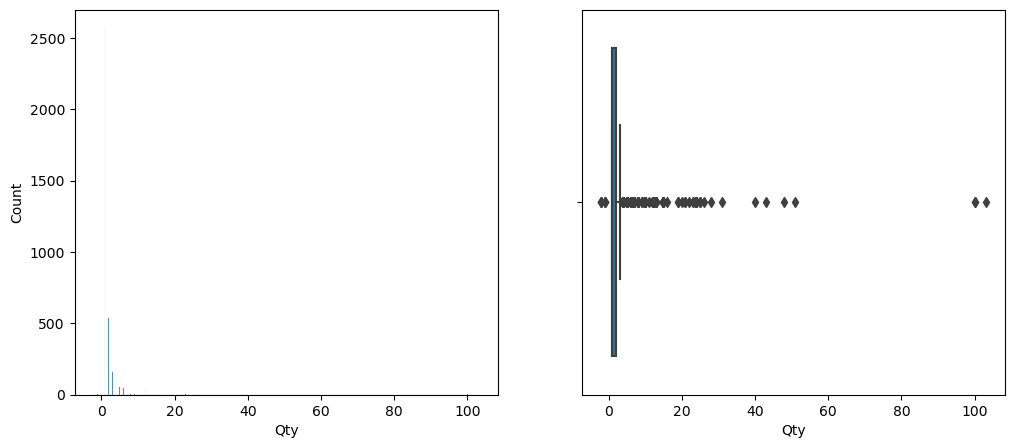

In [10]:
print(df['Nama'].nunique())

plt.subplots(figsize=(12, 5))
plt.subplot(1, 2, 1)
sb.histplot(df['Qty'])

plt.subplot(1, 2, 2)
sb.boxplot(df['Qty'])
plt.show()

### Model Training
**Membagi dataset menjadi training dan testing dengan ratio 70:30**

In [11]:
train = df[:int(0.7*(len(df)))]
test = df[int(0.7*(len(df))):]

X_train = train.drop(['Qty', 'Tahun'], axis=1)
X_test = test.drop(['Qty', 'Tahun'], axis=1)

y_train = train['Qty'].values
y_test = test['Qty'].values

print(X_train.shape, X_test.shape)

(2492, 11) (1068, 11)


**Menguji beberapa algoritma dengan scaler standar dan menentukan yang tepat untuk model**

In [12]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

regressors = [
    KNeighborsRegressor(),
    GradientBoostingRegressor(),
    ExtraTreesRegressor(),
    RandomForestRegressor(),
    DecisionTreeRegressor(),
    LinearRegression(),
    XGBRegressor(),
]

head = 10
for model in regressors[:head]:
    start = time()
    model.fit(X_train, y_train)
    train_time = time() - start
    start = time()
    y_pred = model.predict(X_test)
    predict_time = time()-start    
    print(model)
    print("\tTraining time: %0.3fs" % train_time)
    print("\tPrediction time: %0.3fs" % predict_time)
    print("\tExplained variance:", explained_variance_score(y_test, y_pred))
    print("\tMean absolute error (0 best):", mae(y_test, y_pred))
    print("\tMean absolute percentage error (0 to 1, best):", mape(y_test, y_pred))
    print("\tR2 score (0 to 1, less better):", r2_score(y_test, y_pred))
    print()

KNeighborsRegressor()
	Training time: 0.016s
	Prediction time: 0.080s
	Explained variance: 0.02167989340202725
	Mean absolute error (0 best): 1.253370786516854
	Mean absolute percentage error (0 to 1, best): 0.612540420937671
	R2 score (0 to 1, less better): 0.018238920197930386

GradientBoostingRegressor()
	Training time: 0.579s
	Prediction time: 0.004s
	Explained variance: 0.9367226174075883
	Mean absolute error (0 best): 0.18593004268401384
	Mean absolute percentage error (0 to 1, best): 0.06386467504675752
	R2 score (0 to 1, less better): 0.9366531132911908

ExtraTreesRegressor()
	Training time: 0.768s
	Prediction time: 0.036s
	Explained variance: 0.8678453413753296
	Mean absolute error (0 best): 0.31062734082397003
	Mean absolute percentage error (0 to 1, best): 0.16320675080335045
	R2 score (0 to 1, less better): 0.8674801767997593

RandomForestRegressor()
	Training time: 1.188s
	Prediction time: 0.032s
	Explained variance: 0.9575197571998812
	Mean absolute error (0 best): 0.1013

**Algoritma Terbaik (berdasarkan MAE, MAPE, dan R2): RandomForestRegressor**

**Menguji dan menentukan parameter-parameter yang cocok untuk algoritma yang dipilih**

In [13]:
# parameters = {'bootstrap': [True, False], 'max_features': ['auto', 'sqrt'], 'min_samples_leaf': [1, 2, 4], 'min_samples_split': [2, 5, 10]}

# grid = GridSearchCV(RandomForestRegressor(),parameters)
# model = grid.fit(X_train,y_train)
# print(model.best_params_,'\n')
# print(model.best_estimator_,'\n')

**Melatih model menggunakan algoritma decision tree dengan parameter pilihan untuk menghasilkan akurasi terbaik**

In [14]:
start = time()
# Input Model
# model = DecisionTreeRegressor(max_depth=11, max_features='log2', max_leaf_nodes=90,
#                       min_samples_leaf=5, min_weight_fraction_leaf=0.1)
model = RandomForestRegressor()
model.fit(X_train, y_train)
train_time = time() - start
start = time()
y_pred = model.predict(X_test)
predict_time = time()-start    
print(model)
print("\tTraining time: %0.3fs" % train_time)
print("\tPrediction time: %0.3fs" % predict_time)
print("\tExplained variance:", explained_variance_score(y_test, y_pred))
print("\tMean absolute error (0 best):", mae(y_test, y_pred))
print("\tMean absolute percentage error (0 to 1, best):", mape(y_test, y_pred))
print("\tR2 score (0 to 1, less better):", r2_score(y_test, y_pred))

RandomForestRegressor()
	Training time: 1.127s
	Prediction time: 0.032s
	Explained variance: 0.9546501347534921
	Mean absolute error (0 best): 0.0957397003745318
	Mean absolute percentage error (0 to 1, best): 0.016501724627574713
	R2 score (0 to 1, less better): 0.95428649195953


**Save / Load Model**

In [15]:
import joblib

# Save model
joblib.dump(model, "model.pkl")
# Load model
model2 = joblib.load("model.pkl")

### Prediction

**Load dataset**

In [16]:
# Contoh sementara menggunakan dataset training
Pred = pd.read_excel('ML2.xlsx')
Pred

,Nama,Qty,=,Total,Unit,Harga Per Item,Tanggal
0,CAT CHOIZE ADULT SALMON,1,=,20000,BKS,20000.0,2023-07-01 00:00:00
1,"CAT CHOIZE ADULT TUNA 1KG, 20KG",2,=,38000,BKS,19000.0,2023-07-01 00:00:00
2,CAT LITTER BOX SEMI JUMBO 55.5X45X16.5CM,1,=,130000,PCS,130000.0,2023-07-01 00:00:00
3,CAT LITTER SHOVEL SMALL HOLE,1,=,10000,PCS,10000.0,2023-07-01 00:00:00
4,CAT ME-O POUCH SALMON FLAVOR 15 X 4 SACHETS,2,=,44000,BKS,22000.0,2023-07-01 00:00:00
...,...,...,...,...,...,...,...
3555,MTOP KITTEN TUNA CRANBERRY 24X400G,1,=,17000,KLG,17000.0,15/04/2023
3556,PASIR SENIOR LEMON 10L IKOONA,1,=,60000,SAK,60000.0,15/04/2023
3557,PET CARE WIPES 40PCS,1,=,20000,PCS,20000.0,15/04/2023
3558,PET COMB SELF CLEANING CAT EAR,1,=,25000,PCS,25000.0,15/04/2023


**Drop kolom yang tidak dibutuhkan**


**Encode nama dan unit menjadi datatype yang dapat diproses (fit) oleh model**

In [17]:
## Drop jika dataset tidak memiliki kolom Qty
# Pred = Pred.drop(['='], axis=1)

## Drop jika dataset memiliki kolom Qty
Pred = Pred.drop(['=', 'Qty'], axis=1)

Pred['Nama'] = leNama.transform(Pred['Nama'])
Pred['Unit'] = leUnit.transform(Pred['Unit'])
Pred

,Nama,Total,Unit,Harga Per Item,Tanggal
0,34,20000,1,20000.0,2023-07-01 00:00:00
1,35,38000,1,19000.0,2023-07-01 00:00:00
2,57,130000,6,130000.0,2023-07-01 00:00:00
3,77,10000,6,10000.0,2023-07-01 00:00:00
4,116,44000,1,22000.0,2023-07-01 00:00:00
...,...,...,...,...,...
3555,414,17000,3,17000.0,15/04/2023
3556,504,60000,7,60000.0,15/04/2023
3557,599,20000,6,20000.0,15/04/2023
3558,653,25000,6,25000.0,15/04/2023


**Bagi kolom tanggal menjadi 3 bagian terpisah**

In [18]:
Pred['Tanggal'] = pd.to_datetime(Pred['Tanggal'], dayfirst=True)
Pred['Tanggal'] = Pred['Tanggal'].astype(str)
parts = Pred["Tanggal"].str.split("-", n = 3, expand = True)
Pred["Tahun"]= parts[0].astype('int')
Pred["Bulan"]= parts[1].astype('int')
Pred["Di Tanggal"]= parts[2].astype('int')
Pred

,Nama,Total,Unit,Harga Per Item,Tanggal,Tahun,Bulan,Di Tanggal
0,34,20000,1,20000.0,2023-07-01,2023,7,1
1,35,38000,1,19000.0,2023-07-01,2023,7,1
2,57,130000,6,130000.0,2023-07-01,2023,7,1
3,77,10000,6,10000.0,2023-07-01,2023,7,1
4,116,44000,1,22000.0,2023-07-01,2023,7,1
...,...,...,...,...,...,...,...,...
3555,414,17000,3,17000.0,2023-04-15,2023,4,15
3556,504,60000,7,60000.0,2023-04-15,2023,4,15
3557,599,20000,6,20000.0,2023-04-15,2023,4,15
3558,653,25000,6,25000.0,2023-04-15,2023,4,15


**Menambahkan kolom: hari akhir pekan atau tidak**

In [19]:
Pred['Weekend'] = Pred.apply(lambda x:weekend_or_weekday(x['Tahun'], x['Bulan'], x['Di Tanggal']), axis=1)
Pred

,Nama,Total,Unit,Harga Per Item,Tanggal,Tahun,Bulan,Di Tanggal,Weekend
0,34,20000,1,20000.0,2023-07-01,2023,7,1,1
1,35,38000,1,19000.0,2023-07-01,2023,7,1,1
2,57,130000,6,130000.0,2023-07-01,2023,7,1,1
3,77,10000,6,10000.0,2023-07-01,2023,7,1,1
4,116,44000,1,22000.0,2023-07-01,2023,7,1,1
...,...,...,...,...,...,...,...,...,...
3555,414,17000,3,17000.0,2023-04-15,2023,4,15,1
3556,504,60000,7,60000.0,2023-04-15,2023,4,15,1
3557,599,20000,6,20000.0,2023-04-15,2023,4,15,1
3558,653,25000,6,25000.0,2023-04-15,2023,4,15,1


**Menambahkan kolom: hari libur nasional atau tidak**

In [20]:
Pred['Hari Libur'] = Pred['Tanggal'].apply(is_holiday)
Pred

,Nama,Total,Unit,Harga Per Item,Tanggal,Tahun,Bulan,Di Tanggal,Weekend,Hari Libur
0,34,20000,1,20000.0,2023-07-01,2023,7,1,1,0
1,35,38000,1,19000.0,2023-07-01,2023,7,1,1,0
2,57,130000,6,130000.0,2023-07-01,2023,7,1,1,0
3,77,10000,6,10000.0,2023-07-01,2023,7,1,1,0
4,116,44000,1,22000.0,2023-07-01,2023,7,1,1,0
...,...,...,...,...,...,...,...,...,...,...
3555,414,17000,3,17000.0,2023-04-15,2023,4,15,1,0
3556,504,60000,7,60000.0,2023-04-15,2023,4,15,1,0
3557,599,20000,6,20000.0,2023-04-15,2023,4,15,1,0
3558,653,25000,6,25000.0,2023-04-15,2023,4,15,1,0


**Menambahkan 2 kolom informasi siklus data (untuk fungsi time series)**

In [21]:
Pred['M1'] = np.sin(Pred['Bulan'] * (2 * np.pi / 12))
Pred['M2'] = np.cos(Pred['Bulan'] * (2 * np.pi / 12))
Pred

,Nama,Total,Unit,Harga Per Item,Tanggal,Tahun,Bulan,Di Tanggal,Weekend,Hari Libur,M1,M2
0,34,20000,1,20000.0,2023-07-01,2023,7,1,1,0,-0.500000,-0.866025
1,35,38000,1,19000.0,2023-07-01,2023,7,1,1,0,-0.500000,-0.866025
2,57,130000,6,130000.0,2023-07-01,2023,7,1,1,0,-0.500000,-0.866025
3,77,10000,6,10000.0,2023-07-01,2023,7,1,1,0,-0.500000,-0.866025
4,116,44000,1,22000.0,2023-07-01,2023,7,1,1,0,-0.500000,-0.866025
...,...,...,...,...,...,...,...,...,...,...,...,...
3555,414,17000,3,17000.0,2023-04-15,2023,4,15,1,0,0.866025,-0.500000
3556,504,60000,7,60000.0,2023-04-15,2023,4,15,1,0,0.866025,-0.500000
3557,599,20000,6,20000.0,2023-04-15,2023,4,15,1,0,0.866025,-0.500000
3558,653,25000,6,25000.0,2023-04-15,2023,4,15,1,0,0.866025,-0.500000


**Menambahkan kolom: jenis hari (0=Senin)**

In [22]:
Pred['Hari'] = Pred.apply(lambda x: which_day(x['Tahun'], x['Bulan'], x['Di Tanggal']), axis=1)
Pred

,Nama,Total,Unit,Harga Per Item,Tanggal,Tahun,Bulan,Di Tanggal,Weekend,Hari Libur,M1,M2,Hari
0,34,20000,1,20000.0,2023-07-01,2023,7,1,1,0,-0.500000,-0.866025,5
1,35,38000,1,19000.0,2023-07-01,2023,7,1,1,0,-0.500000,-0.866025,5
2,57,130000,6,130000.0,2023-07-01,2023,7,1,1,0,-0.500000,-0.866025,5
3,77,10000,6,10000.0,2023-07-01,2023,7,1,1,0,-0.500000,-0.866025,5
4,116,44000,1,22000.0,2023-07-01,2023,7,1,1,0,-0.500000,-0.866025,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3555,414,17000,3,17000.0,2023-04-15,2023,4,15,1,0,0.866025,-0.500000,5
3556,504,60000,7,60000.0,2023-04-15,2023,4,15,1,0,0.866025,-0.500000,5
3557,599,20000,6,20000.0,2023-04-15,2023,4,15,1,0,0.866025,-0.500000,5
3558,653,25000,6,25000.0,2023-04-15,2023,4,15,1,0,0.866025,-0.500000,5


****Drop kolom yang tidak dibutuhkan****

In [23]:
Pred.drop(['Tanggal', 'Tahun'], axis=1, inplace=True)
Pred

,Nama,Total,Unit,Harga Per Item,Bulan,Di Tanggal,Weekend,Hari Libur,M1,M2,Hari
0,34,20000,1,20000.0,7,1,1,0,-0.500000,-0.866025,5
1,35,38000,1,19000.0,7,1,1,0,-0.500000,-0.866025,5
2,57,130000,6,130000.0,7,1,1,0,-0.500000,-0.866025,5
3,77,10000,6,10000.0,7,1,1,0,-0.500000,-0.866025,5
4,116,44000,1,22000.0,7,1,1,0,-0.500000,-0.866025,5
...,...,...,...,...,...,...,...,...,...,...,...
3555,414,17000,3,17000.0,4,15,1,0,0.866025,-0.500000,5
3556,504,60000,7,60000.0,4,15,1,0,0.866025,-0.500000,5
3557,599,20000,6,20000.0,4,15,1,0,0.866025,-0.500000,5
3558,653,25000,6,25000.0,4,15,1,0,0.866025,-0.500000,5


**Fit scaler dan prediksi kebutuhan stok (Pred_Y) berdasarkan dataset (Pred_scaled)**

In [24]:
Pred_scaled = scaler.fit_transform(Pred)

Pred_Y = model2.predict(Pred_scaled)
predict_time = time()-start    
print(model2)
print("\tTraining time: %0.3fs" % train_time)
print("\tPrediction time: %0.3fs" % predict_time)

print(Pred_Y.size)
Pred_Y

## Jika ingin menampilkan seluruh hasil prediksi
# with np.printoptions(threshold=np.inf):
#     print(Pred_Y)

RandomForestRegressor()
	Training time: 1.127s
	Prediction time: 62.387s
3560


array([1.  , 2.12, 1.  , ..., 1.  , 1.  , 1.03])

**Transformasi kolom nama yang di encode (menjadi int) kembali (menjadi string)**

In [25]:
Pred['Nama'] = leNama.inverse_transform(Pred['Nama'])
Pred['Unit'] = leNama.inverse_transform(Pred['Unit'])
Pred

,Nama,Total,Unit,Harga Per Item,Bulan,Di Tanggal,Weekend,Hari Libur,M1,M2,Hari
0,CAT CHOIZE ADULT SALMON,20000,BABY CAT 12X195G,20000.0,7,1,1,0,-0.500000,-0.866025,5
1,"CAT CHOIZE ADULT TUNA 1KG, 20KG",38000,BABY CAT 12X195G,19000.0,7,1,1,0,-0.500000,-0.866025,5
2,CAT LITTER BOX SEMI JUMBO 55.5X45X16.5CM,130000,BABYCAT 4K,130000.0,7,1,1,0,-0.500000,-0.866025,5
3,CAT LITTER SHOVEL SMALL HOLE,10000,BABYCAT 4K,10000.0,7,1,1,0,-0.500000,-0.866025,5
4,CAT ME-O POUCH SALMON FLAVOR 15 X 4 SACHETS,44000,BABY CAT 12X195G,22000.0,7,1,1,0,-0.500000,-0.866025,5
...,...,...,...,...,...,...,...,...,...,...,...
3555,MTOP KITTEN TUNA CRANBERRY 24X400G,17000,BABY DOG MILK 2KG,17000.0,4,15,1,0,0.866025,-0.500000,5
3556,PASIR SENIOR LEMON 10L IKOONA,60000,BANTAL LEHER KUCING L,60000.0,4,15,1,0,0.866025,-0.500000,5
3557,PET CARE WIPES 40PCS,20000,BABYCAT 4K,20000.0,4,15,1,0,0.866025,-0.500000,5
3558,PET COMB SELF CLEANING CAT EAR,25000,BABYCAT 4K,25000.0,4,15,1,0,0.866025,-0.500000,5


**Tambahkan hasil prediksi jumlah barang di ujung kanan tabel**

In [26]:
Pred['Quantity'] = Pred_Y
Pred

,Nama,Total,Unit,Harga Per Item,Bulan,Di Tanggal,Weekend,Hari Libur,M1,M2,Hari,Quantity
0,CAT CHOIZE ADULT SALMON,20000,BABY CAT 12X195G,20000.0,7,1,1,0,-0.500000,-0.866025,5,1.00
1,"CAT CHOIZE ADULT TUNA 1KG, 20KG",38000,BABY CAT 12X195G,19000.0,7,1,1,0,-0.500000,-0.866025,5,2.12
2,CAT LITTER BOX SEMI JUMBO 55.5X45X16.5CM,130000,BABYCAT 4K,130000.0,7,1,1,0,-0.500000,-0.866025,5,1.00
3,CAT LITTER SHOVEL SMALL HOLE,10000,BABYCAT 4K,10000.0,7,1,1,0,-0.500000,-0.866025,5,1.00
4,CAT ME-O POUCH SALMON FLAVOR 15 X 4 SACHETS,44000,BABY CAT 12X195G,22000.0,7,1,1,0,-0.500000,-0.866025,5,2.00
...,...,...,...,...,...,...,...,...,...,...,...,...
3555,MTOP KITTEN TUNA CRANBERRY 24X400G,17000,BABY DOG MILK 2KG,17000.0,4,15,1,0,0.866025,-0.500000,5,1.00
3556,PASIR SENIOR LEMON 10L IKOONA,60000,BANTAL LEHER KUCING L,60000.0,4,15,1,0,0.866025,-0.500000,5,1.00
3557,PET CARE WIPES 40PCS,20000,BABYCAT 4K,20000.0,4,15,1,0,0.866025,-0.500000,5,1.00
3558,PET COMB SELF CLEANING CAT EAR,25000,BABYCAT 4K,25000.0,4,15,1,0,0.866025,-0.500000,5,1.00


**Aggregat (totalkan) jumlah kuantitas dengan mengelompokkan berdasarkan nama dan bulan**

In [27]:
Pred_total = Pred.groupby([Pred['Nama'], Pred['Bulan']]).aggregate({'Quantity': 'sum'})
Pred_total.sort_values('Nama')

Quantity
Nama                    Bulan          
BABY CAT  24 X 100 GR   1         17.58
                        2         12.94
                        3         16.98
                        4          2.00
                        7          2.00
...                                 ...
XSMALL PUPPY 500G       6          1.11
                        11         1.11
                        3          1.11
                        4          1.11
YORKSHIRE ADULT 1.5KG   1          1.14

[2499 rows x 1 columns]

**Expor data ke dalam bentuk CSV dan disimpan dalam folder yang sama**

In [28]:
Pred.to_csv('hasil_mentah.csv', encoding='utf-8')
Pred_total.to_csv('hasil.csv', encoding='utf-8')